# Introduction

In this project, we will be looking at the '3G Public Cellular Mobile Telephone Services - Nationwide Service Coverage' data set available on the Data.gov.sg website (2017). We want to see how we can fit a multivariate time series model on the data, and use our model for forecasting. Here, our data set covers the period between 2013 April and 2016 June for the 3 Singapore telephone companies (telcos), Singtel, M1 and Starhub.

If you wish to see the code I used, click the 'Show Code' button at the top of the screen. The code for this was taken from Chris Said (2016).

# Exploratory Data Analysis

We would first like to import the data from the `csv` file that can be downloaded from the website.

In [489]:
#Importing libraries that we will use
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

#Importing data from csv file into a pandas dataframe
data = pd.read_csv('Telco.csv')
data.head(10)

,month,telco,service_coverage
0,2013-04,Singtel,99.11
1,2013-04,M1,97.93
2,2013-04,Starhub,99.25
3,2013-05,Singtel,99.21
4,2013-05,M1,97.87
5,2013-05,Starhub,99.20
6,2013-06,Singtel,99.03
7,2013-06,M1,98.17
8,2013-06,Starhub,99.40
9,2013-07,Singtel,99.33


For our purposes, we will have to reshape the matrix to an  $n×k$  array, where  $n$  is the number of time periods observed, and  $k$  is the number of variables, in this case 3.

In [490]:
data.describe()

,service_coverage
count,117.000000
mean,99.526752
std,0.355913
min,97.870000
25%,99.380000
50%,99.630000
75%,99.730000
max,99.930000


The count of service_coverage is 117, which means there are 39 observations for each telco, which corresponds with the time period we mentioned in the introduction.

In [491]:
#Checking if there are any missing values
data.isnull().any()

month               False
telco               False
service_coverage    False
dtype: bool

Lastly, we note that there is no missing data.

We now wish to visualise our data in a plot. We do this by first converting the month column to datetime, and then using the `pivot` function 

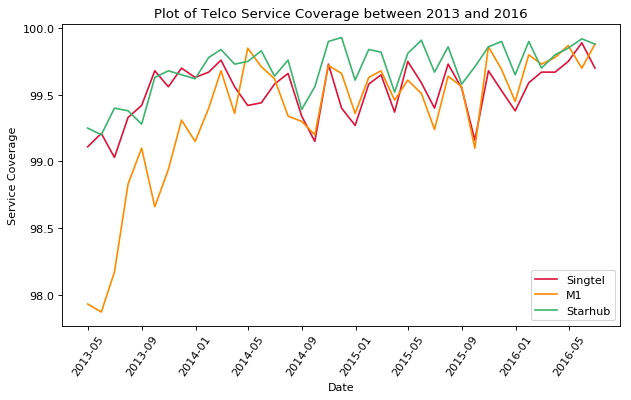

In [492]:
#Pivot the data and convert 'month' to datetime
data2 = data.pivot(index='month', values='service_coverage', columns='telco' )
data2['month'] = pd.date_range('2013/4', '2016/7', freq='M')

#Plot the figure
%matplotlib inline
plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot_date(x=data2['month'][:].values, y=data2['Singtel'][:].values, xdate=True, ydate=False, linestyle='solid', marker='None', label='Singtel', color='crimson')
plt.plot_date(x=data2['month'][:].values, y=data2['M1'][:].values, xdate=True, ydate=False, linestyle='solid', marker='None', label='M1', color='darkorange')
plt.plot_date(x=data2['month'][:].values, y=data2['Starhub'][:].values, xdate=True, ydate=False, linestyle='solid', marker='None', label='Starhub', color='mediumseagreen')
plt.xticks(rotation=55)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Service Coverage')
plt.title('Plot of Telco Service Coverage between 2013 and 2016')

Looking at the plot, we see that M1 had poor performance (by Singaporean standards) in 2013, which could be because it was going through an upgrading exercise (2013). To prevent this from skewing our model, we will only take the time period from January 2014 onwards.

In addition, we also notice that for most of 2014 and 2015, the peaks and troughs of the 3 telcos are largely synchronised. We hope that this feature will be reflected in our time series model.

# Data Preparation

As mentioned above we would like to remove the outlier time period, and thus begin observations from January 2014. We would also like to be able to use our model for forecasting, so we will use April to June 2016 as test data. Now, we reshape the data into the $n\times k$ ndarray as required.

In [493]:
#Remove outlier dates
data3 = data2[data2['month'] >= datetime.strptime('Jan 2014', '%b %Y')]
#Subset train and test data
train_data = data3[data3['month'] < datetime.strptime('Apr 2016', '%b %Y')]
test_data = data3[data3['month'] >= datetime.strptime('Apr 2016', '%b %Y')]
#Convert data to ndarray
train_array = np.array(train_data.drop('month', axis=1))
test_array = np.array(test_data.drop('month', axis=1))
print('Dimension of train_array is', np.shape(train_array))
print('Dimension of test_array is', np.shape(test_array))

Dimension of train_array is (27, 3)
Dimension of test_array is (3, 3)


# Time Series

From here on, we will fit the data as a time series, broadly adopting the methodology illustrated on the Stats Models website (Perktold, Seabold & Taylor, 2017), and with theory detailed by 'New Introduction to Multiple Time Series Analysis' (Lütkepohl, 2005).

Time series data is a set of points that are indexed by time, for example the height of ocean tides, or the price of stocks. It is used in a variety of fields, such as statistics, signal processing, econometrics and finance. We are often interested in time series forecasting, that is using the data that we have to predict future observations. Suppose we wish to make a forecast $h$ steps in the future. Many models for forecasting take the basic form $y_{t+h}=f\left(y_{t}, y_{t-1},\dots,y_{1}\right)$, such that the value of the variable we wish to predict is a function of all previous observations.

We can extend this to multivariate time series, such that at each time step, we observe $k$ different variables. Our forecasting model thus becomes,

$$
\begin{aligned}
y_{1,t+h} &= f_{1}\left(y_{1,t}, y_{2,t},\dots,y_{k,t},y_{1,t-1},\dots,y_{k,1}\right) \\
y_{2,t+h} &= f_{2}\left(y_{1,t}, y_{2,t},\dots,y_{k,t},y_{1,t-1},\dots,y_{k,1}\right) \\
& \vdots \\
y_{k,t+h} &= f_{k}\left(y_{1,t}, y_{2,t},\dots,y_{k,t},y_{1,t-1},\dots,y_{k,1}\right) 
\end{aligned}
$$

Note that the $i^{th}$variable, for $i=1,\dots,k$, at time $t$ may depend on any variable of all past observations, and not just the $i^{th}$variable of the previous observations.

# Vector Autoregressive Processes

An autoregressive (AR) process is a simple model used to model time series data, as it assumes current observations are linear functions of past observations. An autoregressive process with order $p$, or AR$\left(p\right)$ process, takes the form $y_{t}=\nu+\alpha_{1}y_{t-1}+\dots+\alpha_{p}y_{t-p}+\epsilon_{t}$, where $\nu$ and the $\alpha_{i}$ are constants, and $\epsilon_{t}$ is a random error term. We also assume that the $\epsilon_{t}$ at each time step are uncorrelated.

We can extend the AR process to consider multivariate time series as well, and we call this a vector autoregressive (VAR) process. A VAR$\left(p\right)$ process takes the form,

$$
\begin{align}
Y_{t}=\nu+A_{1}Y_{t-1}+\dots+A_{p}Y_{t-p}+\epsilon_{t} \\
\end{align}
$$ where

$
Y_{t}=\begin{pmatrix}y_{1,t}\\ \vdots \\ y_{k,t} \end{pmatrix},\ \nu = \begin{pmatrix}\nu_{1}\\ \vdots \\ \nu_{k} \end{pmatrix},\ A_{i} = \begin{pmatrix} \alpha_{11,i} & \dots & \alpha_{1k,i} \\ \vdots & & \vdots \\ \alpha_{k1,i} & \dots & \alpha_{kk,i} \end{pmatrix},\ $ and $\ \epsilon_{t} = \begin{pmatrix}\epsilon_{1,t}\\ \vdots \\ \epsilon_{k,t} \end{pmatrix}
$|

Note that each $\epsilon_{t}$ consists of an independently and identically distributed random $k$-vector with zero means.

Before we begin to fit the model, we first need to assume that the time series process is stable, that is the reverse characteristic polynomial, $\det\left(I_{k}-A_{1}z -\dots- A_{p}z^{p}\right) \neq 0$ for all $\left|z\right|\leq1$. We can check this by ensuring that the roots of the polynomial all have absolute value greater than 1.

# Model Fitting

## Model Summary

Let us first attempt to fit a VAR$(1)$ model using the `fit` method from the `statsmodels.tsa.api` module, and look at the `summary` of the fit.

In [494]:
#Create VAR object
train_model = VAR(train_array)
#Fit VAR(1) model
train_VAR1 = train_model.fit(1)
train_VAR1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Nov, 2018
Time:                     16:38:15
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -10.5108
Nobs:                     26.0000    HQIC:                  -10.9243
Log likelihood:           45.5118    FPE:                1.53549e-05
AIC:                     -11.0915    Det(Omega_mle):     9.99548e-06
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       100.027129        31.265141            3.199           0.004
L1.y1        -0.009208         0.276229           -0.033           0.974
L1.y2        -0.463614         0.318330           -1.456           0.159
L1.y3         0.467069

In the table above, 'M1' is denoted by `y1`, 'Singtel' by  `y2` and 'Starhub' by `y3`. It shows that we have obtained the coefficients using ordinary least squares regression. We also see that it has provided us for several possible criteria for model selection, such as the Akaike Information Criterion (AIC), the Bayesian Information Criterion (BIC) and Akaike's Final Prediction Error (FPE). Below this, we see the regression coefficients, standard errors, t-statistics and p-values for each of the predictor variables. Unfortunately, none of the coefficients seem to be significant. Lastly, we have the correlation matrix of the residuals.

The above fit is obtained using ordinary least squares estimation. If we define $Y$ and $Z$ as follows,

$$
\begin{align}
Y = \begin{pmatrix} y_{1,1} & \dots & y_{1,t} \\ \vdots & & \vdots \\ y_{k,1} & \dots & y_{k,t}
\end{pmatrix}
\end{align},\quad  Z = \begin{pmatrix} 1 \\ y_{1,t} \\ \vdots \\ y_{k,t} \\ y_{1,t-1} \\ \vdots \\ y_{k,t-p+1} \end{pmatrix}
$$

We can then form the least squares estimator of the coefficients $\hat{B}$ and the unbiased estimator covariance matrix $\hat{\Sigma}_{u}$, 

$$
\begin{align}
\hat{B}= YZ^{T}\left(ZZ^{T}\right)^{-1}, \quad \hat{\Sigma}_{u}=\frac{1}{t-kp-1}Y\left(I_{t}-Z^{T}\left(ZZ^{T}\right)^{-1}Z\right)Y^{T}
\end{align}
$$

where $Z^{T}$ indicates the transpose of $Z$. 

## Lag Order Selection

In order to fit the model, we first need to choose the lag order for our model, ie select $p$ for the VAR$\left(p\right)$ model. We can do this by using the `select_order` method, and choosing $p$ which minimises the AIC. Due to the lack of data, we will use a maximum lag order of 6.

The AIC is defined as follows,

$$
\begin{aligned}
\text{AIC}\left(p\right) &= \log \left|\tilde{\Sigma}_{u}\left(p\right)\right|+\frac{2\dot\times\left(\text{Number of freely estimated parameters}\right)}{t} \\
&= \log \left|\tilde{\Sigma}_{u}\left(p\right)\right|+\frac{2pk^{2}}{t}
\end{aligned}
$$

where $\tilde{\Sigma}_{u}\left(p\right)$ is the maximum likelihood estimate of the covariance matrix. $\tilde{\Sigma}_{u}$ is related to $\hat{\Sigma}_{u}$ by a factor, $\hat{\Sigma}_{u} = \frac{t}{t-kp-1}\tilde{\Sigma}_{u}$. However, both estimators are asymptotically equivalent

In [495]:
train_selection = train_model.select_order(6)
train_selection

                 VAR Order Selection                 
           aic          bic          fpe         hqic
-----------------------------------------------------
0       -11.59       -11.44    9.234e-06       -11.56
1       -11.05       -10.46    1.605e-05       -10.92
2       -11.09       -10.05    1.646e-05       -10.87
3       -11.43       -9.935    1.401e-05       -11.10
4       -11.72       -9.779    1.523e-05       -11.30
5       -12.82       -10.43    1.134e-05       -12.30
6      -49.58*      -46.75*   1.029e-20*      -48.97*
* Minimum



{'aic': 6, 'bic': 6, 'fpe': 6, 'hqic': 6}

We see that the AIC is minimised at $p=6$. We shall use this for our forecasting in the next section.

In [496]:
#Fit VAR(6) model
train_VAR6 = train_model.fit(6)

# Forecasting

Using the `forecast` method, we can obtain the 3-step ahead forecast which is what we wish to use to measure the mean squared error.

In [497]:
train_VAR6.forecast(train_array, 3)

array([[ 99.52903774,  99.59668118,  99.51036518],
       [ 99.24022557,  99.54815744,  99.9469464 ],
       [ 99.51055468,  99.62125482,  99.5291577 ]])

Note that in the table above, the forecast for each variable is presented columnwise, such that the 1-step ahead for Singtel, M1 and Starhub is 99.529, 99.597 and 99.510 respectively, and so on. It is also possible for us to produce forecast intervals,

In [498]:
train_VAR6.forecast_interval(train_array, 1, 0.05)

(array([[ 99.52903774,  99.59668118,  99.51036518]]),
 array([[ 98.88442883,  99.31662208,  99.18302426]]),
 array([[ 100.17364664,   99.87674027,   99.8377061 ]]))

In the table above, we present a the 1-step ahead forecast interval at $\alpha=0.05$. Again, the variables are presented columnwise, such that the 95% forecast interval for M1 is $\left(98.884,100.174\right)$ and so on. We do note that this could imply some model inadequacy, since we know for a fact that the observation cannot exceed 100. We can also produce plots which show this,

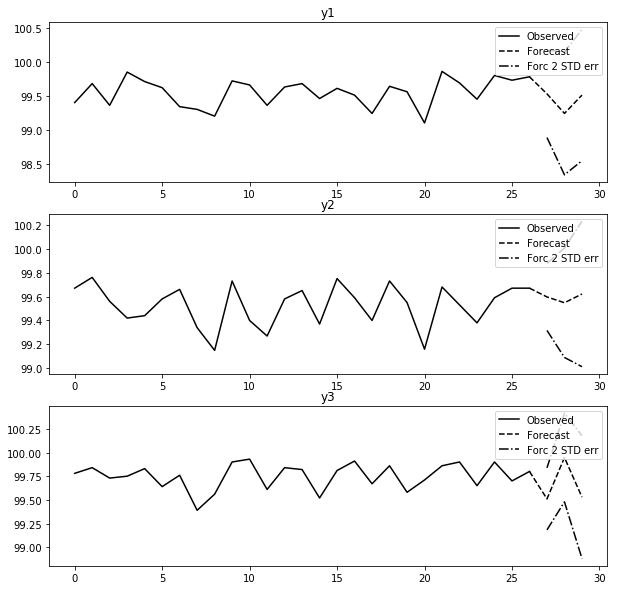

In [499]:
train_VAR6.plot_forecast(3)

Lastly, we would like to compute the mean squared error,

In [500]:
sum(sum((train_VAR6.forecast(train_array, 3)-test_array)**2))/9


0.094429963696167796

We see that the MSE is around 0.0944. However, we do not know how well this model is performing. We can check this by producing the 3-step ahead forecasts using the mean of the training data for each variable as the forecast at each step.

In [501]:
#Calculate means
means = np.mean(train_array, axis=0)
#Use the means as the forecast at each step
means = np.tile(means,(3,1))
#Calculate mean squared error
MSE0 = sum(sum((means-test_array)**2))/9
MSE0

0.054763374485590849

Unfortunately, simply using the mean of the training data seems to perform better than our VAR$\left(6\right)$ model. Let's take this one step further by calculating the MSE for the forecast produced by each VAR$\left(p\right)$ model, for $p=1\dots6$

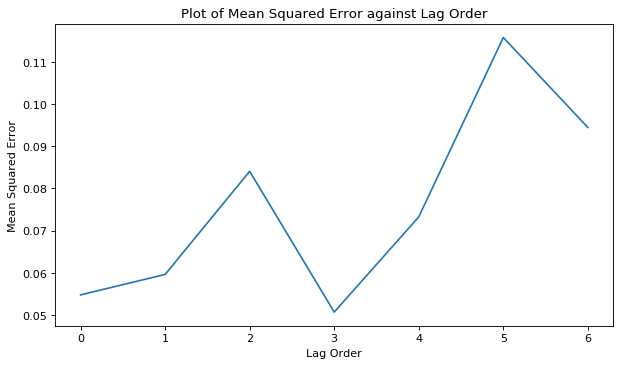

In [502]:
#Initialise array for MSE and fill in first value for MSE from 'null' model
MSE_array = np.zeros(7)
MSE_array[0] = MSE0

#Initialise loop for i=1..6
for i in range(6):
    #Fit VAR model
    train_VAR = train_model.fit(i+1)
    #Produce forecast
    forecast = train_VAR.forecast(train_array, 3)
    #Calculate MSE
    MSE = sum(sum((forecast-test_array)**2))/9
    MSE_array[i+1] = MSE

plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.arange(7), MSE_array)
plt.xlabel('Lag Order')
plt.ylabel('Mean Squared Error')
plt.title('Plot of Mean Squared Error against Lag Order')

We see now that in this case, perhaps selecting a smaller $p$ would have been beneficial.

# Conclusion and Further Improvement

Although our model did not perform up to expectations, I hope that this short report might have helped to introduce time series data and fitting a VAR using the `statsmodels` library. 

As for improving the model itself, as we noted early on the restriction that data cannot go beyond 100 was not imposed. This alone would have implied that the error terms are not normally distributed, and thus OLS regression is not appropriate. In addition, we did not check for stability or trending within the data, and if this were an issue, we might have tried differencing the data first. Lastly, it would have been much more helpful to obtain more data, since the actual data we used for training only consisted of 27 time periods!

Future areas for exploration could include adding more factors to create a panel data set, or employing dynamic vector autoregression, where we use a moving window of data, such that instead of doing a 3-step ahead forecast, we update our model after each observation so that we produce three 1-step ahead forecasts instead.

# References

 1. Government of Singapore. (2017, March). *3G Public Cellular Mobile Telephone Services - Nation-wide Service Coverage*. Retrieved from https://data.gov.sg/dataset/3g-public-cellular-mobile-telephone-services-nation-wide-service-coverage?view_id=d2892dc6-7bcb-4a57-bac7-ed3650415204&resource_id=c7f2dc9d-a1b8-4fca-99fa-91a4ade199d4.
 2. Said, C. (2016, February). *How to make polished Jupyter presentations with optional code visibility*. Retrieved from http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/.
 3. M1. (2013, May). *M1 expands and upgrades 3G network*. Retrieved from https://www.m1.com.sg/AboutM1/NewsReleases/2013/M1%20expands%20and%20upgrades%203G%20network.aspx
 4. Perktold, J, Seabold, S & Taylor, J. (2017). *Vector Autoregressions tsa.vector_ar*. Retrieved from https://www.statsmodels.org/dev/vector_ar.html.
 5. Lütkepohl, H. (2005). *New Introduction to Multiple Time Series Analysis*. Berlin: Springer.